Attentions
==========

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb)
[![Right click and save](https://img.shields.io/badge/Notebook-Open_In_Github-orange.svg)](https://github.com/keisen/tf-keras-vis/blob/master/docs/examples/attentions.ipynb)


This notebook explains how to get various attention images with Saliency, SmoothGrad, GradCAM, GradCAM++ and ScoreCAM/Faster-ScoreCAM.


Preparation
-----------

### Load libraries

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


### Load tf.keras.Model

In this notebook, we use VGG16 model, but if you want to use other tf.keras.Model, you can do so by modifying the section below.

In [3]:
#import tensorflow_addons as tfa

model = tf.keras.models.load_model('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/results/vgg19_line.h5')
#model.summary()

### Load and preprocess images

tf-keras-vis supports batch-wise visualization. Here, we load and preprocess three pictures of goldfish, bear and assault-rifle as input data.

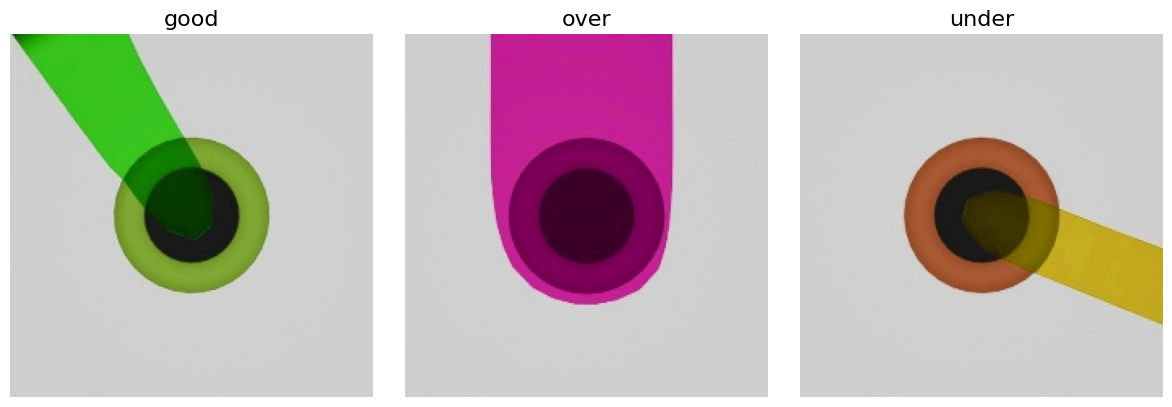

In [4]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg19 import preprocess_input

# Image titles
image_titles = ['good', 'over', 'under']

# Load images and Convert them to a Numpy array
img1 = load_img('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/data/synth_data/augmented_synth_line/test/good/12.jpg', target_size=(224, 224))
img2 = load_img('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/data/synth_data/augmented_synth_line/test/over/1.jpg', target_size=(224, 224))
img3 = load_img('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/data/synth_data/augmented_synth_line/test/under/46.jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data for VGG16
X = preprocess_input(images)

# Rendering
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

Implement functions required to use attentions
----------------------------------------------

### Model modifier

When the softmax activation function is applied to the last layer of model, it may obstruct generating the attention images, so you should replace the function to a linear activation function. Although we create and use `ReplaceToLinear` instance here, we can also use the model modifier function defined by ourselves.

In [5]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

### Score function

And then, you **MUST** create `Score` instance or define `score function` that returns target scores. Here, they return the score values corresponding Goldfish, Bear, Assault Rifle.

In [9]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([0,1,2])

# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refers to the output of the model,
    # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
    return (output[0][1], output[1][3], output[2][4])

## Vanilla Saliency

`Saliency` generates a saliency map that appears the regions of ​​the input image that contributes the most to the output value.

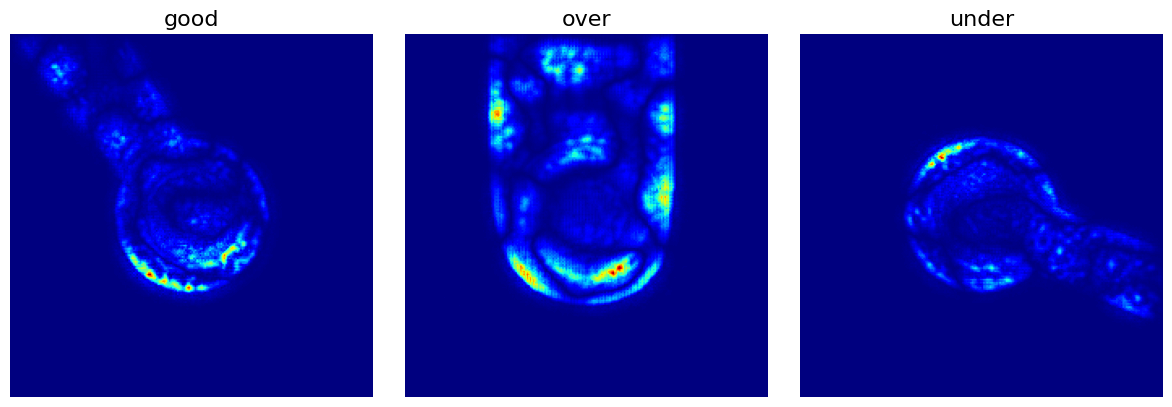

CPU times: user 7.07 s, sys: 561 ms, total: 7.63 s
Wall time: 1.33 s


In [10]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
saliency_map = saliency(score, X)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## SmoothGrad

As you can see above, Vanilla Saliency map is too noisy, so let's remove noise in the saliency map using SmoothGrad! SmoothGrad is a method that reduce the noise in saliency map by adding noise to input image.

**Note:** Because SmoothGrad calculates the gradient repeatedly, it might take much time around 2-3 minutes when using CPU.

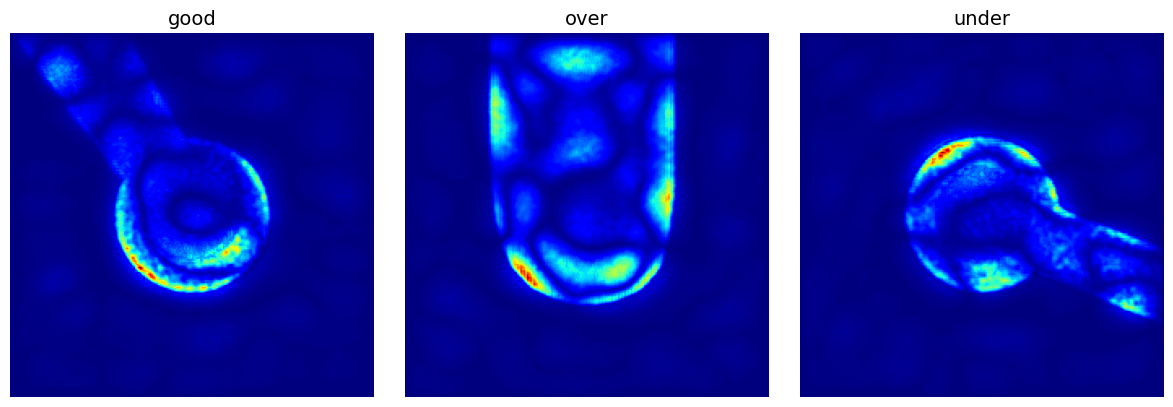

CPU times: user 2min 2s, sys: 5.4 s, total: 2min 8s
Wall time: 20.7 s


In [11]:
%%time

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
#plt.savefig('images/smoothgrad.png')
plt.show()

## GradCAM

Saliency is one of useful way of visualizing attention that appears the regions of the input image that contributes the most to the output value.
GradCAM is another way of visualizing attention over input. Instead of using gradients of model outputs, it uses of penultimate layer output (that is the convolutional layer just before Dense layers).

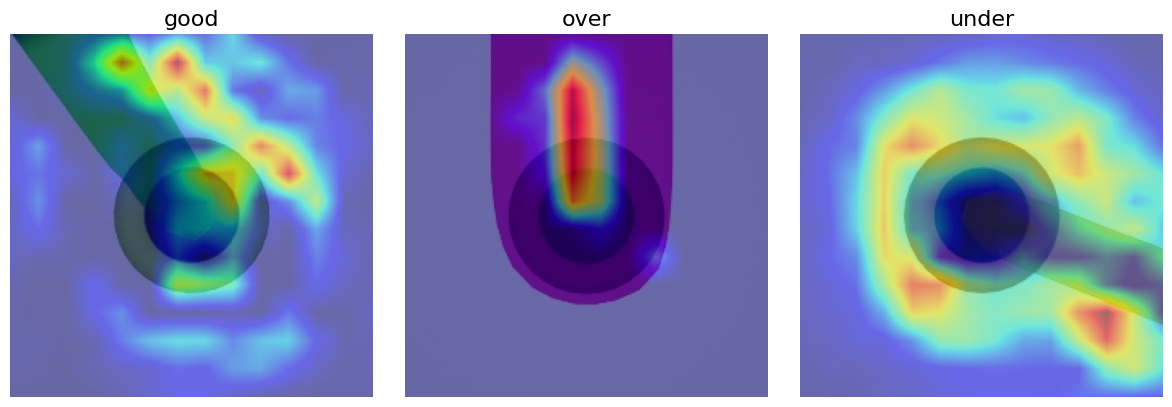

CPU times: user 6.92 s, sys: 422 ms, total: 7.35 s
Wall time: 1.45 s


In [12]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## GradCAM++

GradCAM++ can provide better visual explanations of CNN model predictions.

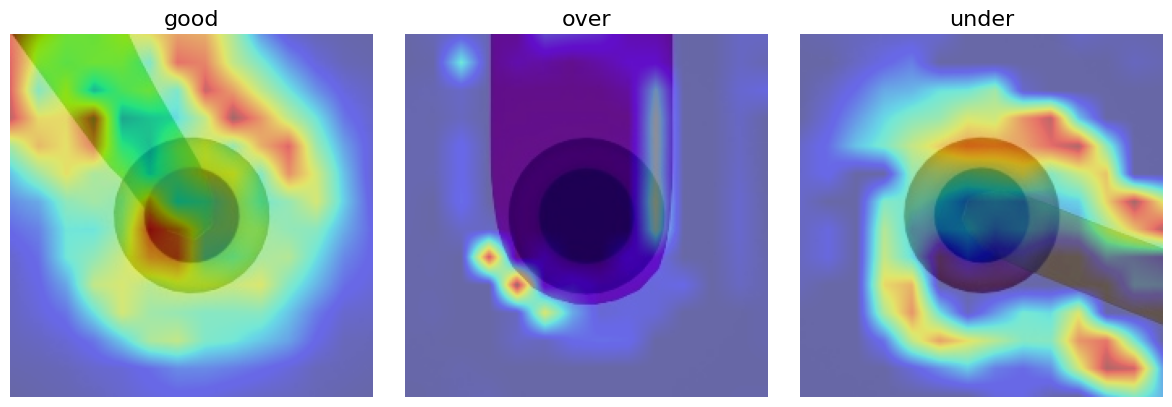

CPU times: user 6.95 s, sys: 387 ms, total: 7.34 s
Wall time: 1.43 s


In [13]:
%%time

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Create GradCAM++ object
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)

# Generate heatmap with GradCAM++
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
#plt.savefig('images/gradcam_plus_plus.png')
plt.show()

# Big Run

In [ ]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import load_img
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
replace2linear = ReplaceToLinear()


from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([0,1,2])

'''
# assign directory
directory = '/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/results'
models = {}
# iterate over files in
# that directory
for filename in os.listdir(directory):
	if
	f = os.path.join(directory, filename)
	# checking if it is a file
	if os.path.isfile(f):
		models[filename.split('.')[0]] = tf.keras.models.load_model(f)
'''

models ={"vgg19_line" : tf.keras.models.load_model('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/results/vgg19_line.h5'),
		 "vgg19_infill" : tf.keras.models.load_model('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/results/vgg19_infill.h5'),
         "MobileNetV3_line" : tf.keras.models.load_model('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/results/MobileNetV3Small_line.h5'),
		 "MobileNetV3_infill" : tf.keras.models.load_model('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/results/MobileNetV3Small_infill.h5'),
         "ResNet50_line" : tf.keras.models.load_model('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/results/ResNet50V2_line.h5'),
		 "ResNet50_infill" : tf.keras.models.load_model('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/results/ResNet50V2_infill.h5'),
         "Xception_line" : tf.keras.models.load_model('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/results/Xception_line.h5'),
		 "Xception_infill" : tf.keras.models.load_model('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/results/Xception_infill.h5')}
# Image titles
image_titles = ['good', 'over', 'under']

# Load images and Convert them to a Numpy array
img1 = load_img('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/data/synth_data/augmented_synth_line/test/good/12.jpg', target_size=(224, 224))
img2 = load_img('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/data/synth_data/augmented_synth_line/test/over/1.jpg', target_size=(224, 224))
img3 = load_img('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/data/synth_data/augmented_synth_line/test/under/46.jpg', target_size=(224, 224))
images1 = np.asarray([np.array(img1), np.array(img2), np.array(img3)])
#images1 = np.asarray([np.array(img1)])
img4 = load_img('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/data/synth_data/augmented_synth_infill/test/good/13.jpg', target_size=(224, 224))
img5 = load_img('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/data/synth_data/augmented_synth_infill/test/over/12.jpg', target_size=(224, 224))
img6 = load_img('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/data/synth_data/augmented_synth_infill/test/under/47.jpg', target_size=(224, 224))
images2 = np.asarray([np.array(img4), np.array(img5), np.array(img6)])
#images2 = np.asarray([np.array(img4)])

X={}


X["vgg19_line"] = tf.keras.applications.vgg19.preprocess_input(images1)
X["MobileNetV3_line"] = tf.keras.applications.mobilenet_v3.preprocess_input(images1).astype(np.float32)
X["ResNet50_line"] = tf.keras.applications.resnet_v2.preprocess_input(images1).astype(np.float32)
X["Xception_line"] = tf.keras.applications.xception.preprocess_input(images1).astype(np.float32)
X["vgg19_infill"] = tf.keras.applications.vgg19.preprocess_input(images2)
X["MobileNetV3_infill"] = tf.keras.applications.mobilenet_v3.preprocess_input(images2).astype(np.float32)
X["ResNet50_infill"] = tf.keras.applications.resnet_v2.preprocess_input(images2).astype(np.float32)
X["Xception_infill"] = tf.keras.applications.xception.preprocess_input(images2).astype(np.float32)
'''
# Preparing input data for each model
for k in models:
	if "vgg19" in k:
		X[k] = tf.keras.applications.vgg19.preprocess_input(images)
	elif "MobileNetV3" in k:
		X[k] = tf.keras.applications.mobilenet_v3.preprocess_input(images).astype(np.float32)
	elif "ResNet" in k:
		X[k] = tf.keras.applications.resnet_v2.preprocess_input(images).astype(np.float32)
	elif "Xception" in k:
		X[k] = tf.keras.applications.xception.preprocess_input(images).astype(np.float32)
'''

saliency_maps = []
smooth_grads = []
gradcams = []
gradcamspp = []
for m in models:
	# Create Saliency object.
	print(m)
	saliency = Saliency(models[m],
						model_modifier=replace2linear,
						clone=True)

	# Generate saliency map
	saliency_maps.append(saliency(score, X[m]))
	# Generate SmoothGrad
	smooth_grads.append(saliency(score,
                        X[m],
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20)) # noise spread level.
	
	# Create Gradcam object
	gradcam = Gradcam(models[m],
                  model_modifier=replace2linear,
                  clone=True)

	# Generate heatmap with GradCAM
	gradcams.append(gradcam(score,
              X[m],
              penultimate_layer=-1))
	
	# Create GradcamPlusPlus object
	gradcampp = GradcamPlusPlus(models[m],
                  model_modifier=replace2linear,
                  clone=True)

	# Generate heatmap with GradcamPlusPlus
	gradcamspp.append(gradcampp(score,
              X[m],
              penultimate_layer=-1))
	
	

# Render
f, ax = plt.subplots(nrows=len(models), ncols=4, figsize=(12,len(models)))
y=0
ax[0][1].set_title("Saliency")
ax[0][4].set_title("SmoothGrad")
ax[0][7].set_title("GradCam")
ax[0][10].set_title("GradCam++")
for m in models:
	if "line" in m:
		images = images1
	else:
		images = images2
		
	ax[y][0].set_ylabel(m, rotation=45)
	ax[y][0].yaxis.set_label_coords(-0.7, 0.5)
	
	for x in range(len(images1)):
		ax[y][x].imshow(saliency_maps[y][x], cmap='jet')
		ax[y][x].set_xticks([])
		ax[y][x].set_yticks([])
	for x in range(len(images1)):
		ax[y][x+3].imshow(smooth_grads[y][x], cmap='jet')
		ax[y][x+3].set_xticks([])
		ax[y][x+3].set_yticks([])
	for x in range(len(images1)):
		heatmap = np.uint8(cm.jet(gradcams[y][x])[..., :3] * 255)
		ax[y][x+6].imshow(images[x])
		ax[y][x+6].imshow(heatmap, cmap='jet', alpha=0.7) # overlay
		ax[y][x+6].set_xticks([])
		ax[y][x+6].set_yticks([])
	for x in range(len(images1)):
		heatmap = np.uint8(cm.jet(gradcamspp[y][x])[..., :3] * 255)
		ax[y][x+9].imshow(images[x])
		ax[y][x+9].imshow(heatmap, cmap='jet', alpha=0.7) # overlay
		ax[y][x+9].set_xticks([])
		ax[y][x+9].set_yticks([])
	y+=1

plt.tight_layout()
plt.show()



vgg19_line
vgg19_infill
MobileNetV3_line
MobileNetV3_infill
ResNet50_line
ResNet50_infill
Xception_line
Xception_infill


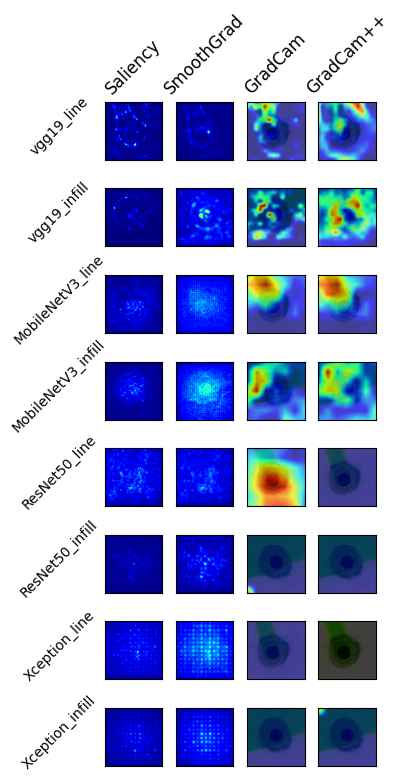

In [3]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import load_img
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
replace2linear = ReplaceToLinear()


from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([0,1,2])

'''
# assign directory
directory = '/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/results'
models = {}
# iterate over files in
# that directory
for filename in os.listdir(directory):
	if
	f = os.path.join(directory, filename)
	# checking if it is a file
	if os.path.isfile(f):
		models[filename.split('.')[0]] = tf.keras.models.load_model(f)
'''

models ={"vgg19_line" : tf.keras.models.load_model('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/results-real/vgg19_line.h5'),
		 "vgg19_infill" : tf.keras.models.load_model('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/results-real/vgg19_infill.h5'),
         "MobileNetV3_line" : tf.keras.models.load_model('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/results-real/MobileNetV3Small_line.h5'),
		 "MobileNetV3_infill" : tf.keras.models.load_model('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/results-real/MobileNetV3Small_infill.h5'),
         "ResNet50_line" : tf.keras.models.load_model('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/results-real/ResNet50V2_line.h5'),
		 "ResNet50_infill" : tf.keras.models.load_model('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/results-real/ResNet50V2_infill.h5'),
         "Xception_line" : tf.keras.models.load_model('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/results-real/Xception_line.h5'),
		 "Xception_infill" : tf.keras.models.load_model('/Users/daniel/Documents/aiPrint-Publishable/aiPrint-Data-Creation/cnn-training/results-real/Xception_infill.h5')}
# Image titles
image_titles = ['good', 'over', 'under']

# Load images and Convert them to a Numpy array
img1 = load_img('/Users/daniel/Documents/CNN Training/real_data/augmented_real_line/test/good/400.jpg', target_size=(224, 224))
img2 = load_img('/Users/daniel/Documents/CNN Training/real_data/augmented_real_line/test/over/1.jpg', target_size=(224, 224))
img3 = load_img('/Users/daniel/Documents/CNN Training/real_data/augmented_real_line/test/under/46.jpg', target_size=(224, 224))
images1 = np.asarray([np.array(img1), np.array(img2), np.array(img3)])
#images1 = np.asarray([np.array(img1)])
img4 = load_img('/Users/daniel/Documents/CNN Training/real_data/augmented_real_infill/test/good/400.jpg', target_size=(224, 224))
img5 = load_img('/Users/daniel/Documents/CNN Training/real_data/augmented_real_infill/test/over/12.jpg', target_size=(224, 224))
img6 = load_img('/Users/daniel/Documents/CNN Training/real_data/augmented_real_infill/test/under/47.jpg', target_size=(224, 224))
images2 = np.asarray([np.array(img4), np.array(img5), np.array(img6)])
#images2 = np.asarray([np.array(img4)])

X={}


X["vgg19_line"] = tf.keras.applications.vgg19.preprocess_input(images1)
X["MobileNetV3_line"] = tf.keras.applications.mobilenet_v3.preprocess_input(images1).astype(np.float32)
X["ResNet50_line"] = tf.keras.applications.resnet_v2.preprocess_input(images1).astype(np.float32)
X["Xception_line"] = tf.keras.applications.xception.preprocess_input(images1).astype(np.float32)
X["vgg19_infill"] = tf.keras.applications.vgg19.preprocess_input(images2)
X["MobileNetV3_infill"] = tf.keras.applications.mobilenet_v3.preprocess_input(images2).astype(np.float32)
X["ResNet50_infill"] = tf.keras.applications.resnet_v2.preprocess_input(images2).astype(np.float32)
X["Xception_infill"] = tf.keras.applications.xception.preprocess_input(images2).astype(np.float32)
'''
# Preparing input data for each model
for k in models:
	if "vgg19" in k:
		X[k] = tf.keras.applications.vgg19.preprocess_input(images)
	elif "MobileNetV3" in k:
		X[k] = tf.keras.applications.mobilenet_v3.preprocess_input(images).astype(np.float32)
	elif "ResNet" in k:
		X[k] = tf.keras.applications.resnet_v2.preprocess_input(images).astype(np.float32)
	elif "Xception" in k:
		X[k] = tf.keras.applications.xception.preprocess_input(images).astype(np.float32)
'''

saliency_maps = []
smooth_grads = []
gradcams = []
gradcamspp = []
for m in models:
	# Create Saliency object.
	print(m)
	saliency = Saliency(models[m],
						model_modifier=replace2linear,
						clone=True)

	# Generate saliency map
	saliency_maps.append(saliency(score, X[m]))
	# Generate SmoothGrad
	smooth_grads.append(saliency(score,
                        X[m],
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20)) # noise spread level.
	
	# Create Gradcam object
	gradcam = Gradcam(models[m],
                  model_modifier=replace2linear,
                  clone=True)

	# Generate heatmap with GradCAM
	gradcams.append(gradcam(score,
              X[m],
              penultimate_layer=-1))
	
	# Create GradcamPlusPlus object
	gradcampp = GradcamPlusPlus(models[m],
                  model_modifier=replace2linear,
                  clone=True)

	# Generate heatmap with GradcamPlusPlus
	gradcamspp.append(gradcampp(score,
              X[m],
              penultimate_layer=-1))
	
	

# Render
f, ax = plt.subplots(nrows=len(models), ncols=4, figsize=(4,len(models)))
y=0
ax[0][0].set_title("Saliency",rotation=45)
ax[0][1].set_title("SmoothGrad",rotation=45)
ax[0][2].set_title("GradCam",rotation=45)
ax[0][3].set_title("GradCam++",rotation=45)
for m in models:
	if "line" in m:
		images = images1
	else:
		images = images2
		
	ax[y][0].set_ylabel(m, rotation=45)
	ax[y][0].yaxis.set_label_coords(-0.7, 0.5)
	
	for x in range(1):
		ax[y][x].imshow(saliency_maps[y][x], cmap='jet')
		ax[y][x].set_xticks([])
		ax[y][x].set_yticks([])
	for x in range(1):
		ax[y][x+1].imshow(smooth_grads[y][x], cmap='jet')
		ax[y][x+1].set_xticks([])
		ax[y][x+1].set_yticks([])
	for x in range(1):
		heatmap = np.uint8(cm.jet(gradcams[y][x])[..., :3] * 255)
		ax[y][x+2].imshow(images[x])
		ax[y][x+2].imshow(heatmap, cmap='jet', alpha=0.7) # overlay
		ax[y][x+2].set_xticks([])
		ax[y][x+2].set_yticks([])
	for x in range(1):
		heatmap = np.uint8(cm.jet(gradcamspp[y][x])[..., :3] * 255)
		ax[y][x+3].imshow(images[x])
		ax[y][x+3].imshow(heatmap, cmap='jet', alpha=0.7) # overlay
		ax[y][x+3].set_xticks([])
		ax[y][x+3].set_yticks([])
	y+=1

plt.tight_layout()
#plt.show()
plt.savefig("attentions.png",dpi=300)
